# Preprocessing

In [74]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
from itertools import chain
from tqdm.notebook import tqdm
from scipy.stats import entropy, ks_2samp
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
from fixation3d import extract_fixations

In [2]:
participant_paths = [entry.path for entry in os.scandir("../data/input") if "EmbracePlus" not in entry.path]

In [3]:
def load_csv(file_path):
    sensor_df = pd.read_csv(file_path)
    sensor_df["timestamp"] = pd.to_datetime(sensor_df["timestamp"], unit="ms").dt.tz_localize("CET")
    return sensor_df

In [4]:
participant_data = {}
for path in participant_paths:
    participant_id = int(path.split("_P")[-1]) - 100
    participant_data[participant_id] = {}
    participant_data[participant_id]["eye_ray"] = load_csv(f"{path}/hololens2_eye_ray.csv")
    participant_data[participant_id]["hand_pose"] = load_csv(f"{path}/hololens2_hand_pose.csv")
    participant_data[participant_id]["head_pose"] = load_csv(f"{path}/hololens2_head_pose.csv")
    participant_data[participant_id]["bvp"] = load_csv(f"{path}/empatica_e4_bvp.csv")
    participant_data[participant_id]["eda"] = load_csv(f"{path}/empatica_e4_eda.csv")
    participant_data[participant_id]["temperature"] = load_csv(f"{path}/empatica_e4_tmp.csv")

## Trial data

In [5]:
tag_data = {}
for path in participant_paths:
    participant_id = int(path.split("_P")[-1]) - 100
    with open(f"{path}/tag.csv", "r") as f:
        next(f)
        tags = [line.strip().split(",", 1) for line in f]
    tag_df = pd.DataFrame(tags, columns=["timestamp", "label"])
    tag_df["label"] = tag_df["label"].apply(lambda x: eval(x))
    tag_df["timestamp"] = pd.to_datetime(tag_df["timestamp"].astype(float), unit="ms").dt.tz_localize("CET")
    tag_data[participant_id] = tag_df

In [6]:
trial_df = pd.DataFrame()
for participant_id in tag_data.keys():
    tag_df = tag_data[participant_id]
    tag_df["participant_id"] = participant_id
    tag_df["start_of_trial"] = tag_df["label"].apply(lambda label: label["start_of_trial"])
    tag_df["puzzle_id"] = tag_df["label"].apply(lambda label: str(int(label["puzzle_id"]))) # " 1" -> "1"
    tag_df["condition"] = tag_df["label"].apply(lambda label: label["condition"])
    tag_df["skip"] = tag_df["label"].apply(lambda label: label["skip"])
    tag_df["cognitive_load"] = (tag_df["condition"] == "2").astype(int)

    # deal with duplicated puzzles (when participant ran out of puzzles)
    tag_df["puzzle_count"] = tag_df.groupby("puzzle_id").cumcount()
    tag_df.loc[tag_df["puzzle_count"] >= 2, "puzzle_id"] += "'"
    tag_df.drop(columns=["puzzle_count"], inplace=True)

    start_df = tag_df.loc[
        tag_df["start_of_trial"] == True, ["timestamp", "participant_id", "puzzle_id", "cognitive_load"]
    ].rename(columns={"timestamp": "start_time"})
    end_df = tag_df.loc[
        tag_df["start_of_trial"] == False, ["timestamp", "puzzle_id", "skip"]
    ].rename(columns={"timestamp": "end_time"})
    trial_df_ = start_df.merge(end_df, on=["puzzle_id"], how="left")

    # missing `end_time` and `skip` for last trial of each condition: time was up (15 min)
    trial_df_["skip"] = trial_df_["skip"].astype("boolean").fillna(False)
    for index, trial in trial_df_[trial_df_["end_time"].isna()].iterrows():
        start_time = trial_df_.loc[trial_df_["cognitive_load"] == trial["cognitive_load"], "start_time"].iloc[0]
        trial_df_.loc[index, "end_time"] = start_time + pd.Timedelta(minutes=15)
    
    if trial_df.empty:
        trial_df = trial_df_
    else:
        trial_df = pd.concat([trial_df, trial_df_], ignore_index=True)

trial_df.head()

,start_time,participant_id,puzzle_id,cognitive_load,end_time,skip
0,2025-01-29 13:05:43.529607910+01:00,2,69,1,2025-01-29 13:11:02.531682129+01:00,True
1,2025-01-29 13:11:02.565684082+01:00,2,58,1,2025-01-29 13:14:50.125843994+01:00,False
2,2025-01-29 13:14:50.204845947+01:00,2,71,1,2025-01-29 13:20:07.283221924+01:00,True
3,2025-01-29 13:20:07.329221924+01:00,2,62,1,2025-01-29 13:20:43.529607910+01:00,False
4,2025-01-29 13:22:50.784409912+01:00,2,3,0,2025-01-29 13:23:17.594857910+01:00,False


In [7]:
trial_df["duration"] = (trial_df["end_time"] - trial_df["start_time"]).dt.total_seconds()
trial_df

,start_time,participant_id,puzzle_id,cognitive_load,end_time,skip,duration
0,2025-01-29 13:05:43.529607910+01:00,2,69,1,2025-01-29 13:11:02.531682129+01:00,True,319.002074
1,2025-01-29 13:11:02.565684082+01:00,2,58,1,2025-01-29 13:14:50.125843994+01:00,False,227.560160
2,2025-01-29 13:14:50.204845947+01:00,2,71,1,2025-01-29 13:20:07.283221924+01:00,True,317.078376
3,2025-01-29 13:20:07.329221924+01:00,2,62,1,2025-01-29 13:20:43.529607910+01:00,False,36.200386
4,2025-01-29 13:22:50.784409912+01:00,2,3,0,2025-01-29 13:23:17.594857910+01:00,False,26.810448
...,...,...,...,...,...,...,...
779,2025-02-12 16:12:46.113789062+01:00,24,32,0,2025-02-12 16:13:13.377490967+01:00,False,27.263702
780,2025-02-12 16:13:13.406491943+01:00,24,33,0,2025-02-12 16:13:49.826340820+01:00,False,36.419849
781,2025-02-12 16:13:49.853343994+01:00,24,34,0,2025-02-12 16:14:12.765440918+01:00,False,22.912097
782,2025-02-12 16:14:12.790437012+01:00,24,35,0,2025-02-12 16:14:49.859921875+01:00,False,37.069485


In [8]:
trial_df["duration"].describe()

count    784.000000
mean      52.776642
std       80.666264
min        2.492069
25%       23.434884
50%       28.788701
75%       37.174712
max      781.764388
Name: duration, dtype: float64

## Feature engineering

In [63]:
# the same values should be used for all modalities
window_size = 10
step_size = 1

### Useful functions

In [9]:
def generate_trial_windows(trial_start, trial_end, window_size=10, step_size=1): 
    current_time = trial_start
    while current_time + pd.Timedelta(seconds=window_size) <= trial_end:
        start_time, end_time = current_time, current_time + pd.Timedelta(seconds=window_size)
        yield (start_time, end_time)
        current_time += pd.Timedelta(seconds=step_size)

In [10]:
def get_random_window(
    participant_id=None, cognitive_load=None, trial_id=None, window_size=10, step_size=1
):
    """For debugging."""

    if not participant_id:
        participant_id = random.choice(list(participant_data.keys()))
    if not cognitive_load:
        cognitive_load = random.choice([0, 1])
    if not trial_id:
        trial_id = random.choice(
            list(
                trial_df[
                    (trial_df["participant_id"] == participant_id)
                    & (trial_df["cognitive_load"] == cognitive_load)
                ].index[
                    :-1
                ]  # exclude last trial, which could be too short
            )
        )
    trial_start, trial_end = trial_df.loc[
        (trial_df["participant_id"] == participant_id) & (trial_df.index == trial_id), ["start_time", "end_time"]
    ].values[0]
    start_time, end_time = random.choice(
        [
            window
            for window in generate_trial_windows(
                trial_start, trial_end, window_size, step_size
            )
        ]
    )
    window_dict = dict()
    for sensor in participant_data[participant_id].keys():
        window_dict[sensor] = (
            participant_data[participant_id][sensor]
            .loc[
                participant_data[participant_id][sensor]["timestamp"].between(
                    start_time, end_time
                )
            ]
            .copy()
        )
    print(
        f"Participant: {participant_id}, Cognitive Load: {cognitive_load}, Trial ID: {trial_id}, Time between {start_time} and {end_time}"
    )
    return window_dict


get_random_window()["eye_ray"]

Participant: 20, Cognitive Load: 0, Trial ID: 619, Time between 2025-02-07 15:22:15.283356934+01:00 and 2025-02-07 15:22:25.283356934+01:00


,timestamp,origin_x,origin_y,origin_z,direction_x,direction_y,direction_z
38024,2025-02-07 15:22:15.288728027+01:00,-0.031238,-0.013485,-0.342639,-0.058853,-0.818064,-0.572111
38025,2025-02-07 15:22:15.336052979+01:00,-0.027054,-0.014248,-0.342483,-0.070418,-0.816784,-0.572634
38026,2025-02-07 15:22:15.383725830+01:00,-0.024010,-0.014357,-0.341967,-0.076161,-0.809695,-0.581892
38027,2025-02-07 15:22:15.430929932+01:00,-0.021409,-0.013999,-0.341265,-0.080245,-0.801445,-0.592664
38028,2025-02-07 15:22:15.478714844+01:00,-0.019904,-0.013583,-0.340436,-0.081305,-0.791321,-0.605973
...,...,...,...,...,...,...,...
38232,2025-02-07 15:22:25.092255127+01:00,-0.044907,-0.007714,-0.324917,-0.267956,-0.758669,-0.593823
38233,2025-02-07 15:22:25.138955078+01:00,-0.044091,-0.008164,-0.325625,-0.262755,-0.761532,-0.592481
38234,2025-02-07 15:22:25.186302002+01:00,NaN,NaN,NaN,NaN,NaN,NaN
38235,2025-02-07 15:22:25.233660889+01:00,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
def signal_features_for_sensor(sensor, window_df):
    feature_dict = dict()
    window_df.columns = [f"{sensor}_{column}" for column in window_df.columns]
    for column in window_df.columns:
        if not window_df[column].dropna().empty:
            feature_dict[f"{column}_mean"] = window_df[column].mean()
            feature_dict[f"{column}_std"] = window_df[column].std()
            feature_dict[f"{column}_median"] = window_df[column].median()
            feature_dict[f"{column}_mad"] = np.nanmean(np.abs(window_df[column] - feature_dict[f"{column}_mean"]))
            feature_dict[f"{column}_min"] = window_df[column].min()
            feature_dict[f"{column}_max"] = window_df[column].max()
            feature_dict[f"{column}_range"] = window_df[column].max() - window_df[column].min()
            feature_dict[f"{column}_iqr"] = window_df[column].quantile(0.75) - window_df[column].quantile(0.25)
            feature_dict[f"{column}_skew"] = window_df[column].skew()
            feature_dict[f"{column}_kurtosis"] = window_df[column].kurt()
            feature_dict[f"{column}_energy"] = np.nanmean(window_df[column] ** 2)
            feature_dict[f"{column}_rms"] = np.sqrt(np.nanmean(window_df[column] ** 2))
            frequencies, psd_vals = welch(window_df[column], nperseg=min(256, window_df[column].shape[0]))
            if np.nansum(psd_vals) != 0:
                feature_dict[f"{column}_max_freq"] = frequencies[np.argmax(psd_vals)]
                feature_dict[f"{column}_mean_freq"] = np.nansum(frequencies * psd_vals) / np.nansum(psd_vals)
                feature_dict[f"{column}_entropy"] = entropy(psd_vals)
                feature_dict[f"{column}_psd"] = np.nansum(psd_vals)
    return feature_dict

example_hand_feature_columns = pd.DataFrame({
    "angular_distance": [11, 2, 5, 1, np.nan],
    "left_contralateral_distance": [3, 6, -3, -1, np.nan],
    "left_contralateral_distance_relu": [3, 6, 0, 0, np.nan], 
})
signal_features_for_sensor("hand", example_hand_feature_columns)

{'hand_angular_distance_mean': np.float64(4.75),
 'hand_angular_distance_std': np.float64(4.5),
 'hand_angular_distance_median': np.float64(3.5),
 'hand_angular_distance_mad': np.float64(3.25),
 'hand_angular_distance_min': np.float64(1.0),
 'hand_angular_distance_max': np.float64(11.0),
 'hand_angular_distance_range': np.float64(10.0),
 'hand_angular_distance_iqr': np.float64(4.75),
 'hand_angular_distance_skew': np.float64(1.2482853223593964),
 'hand_angular_distance_kurtosis': np.float64(0.9760707209266872),
 'hand_angular_distance_energy': np.float64(37.75),
 'hand_angular_distance_rms': np.float64(6.144102863722254),
 'hand_left_contralateral_distance_mean': np.float64(1.25),
 'hand_left_contralateral_distance_std': np.float64(4.031128874149275),
 'hand_left_contralateral_distance_median': np.float64(1.0),
 'hand_left_contralateral_distance_mad': np.float64(3.25),
 'hand_left_contralateral_distance_min': np.float64(-3.0),
 'hand_left_contralateral_distance_max': np.float64(6.0),
 

### HoloLens

#### Eye ray

In [12]:
def process_eye_ray(window_df):
    fixation_df = extract_fixations(
        window_df.dropna()
    )
    if fixation_df.empty:
        return pd.Series()
    fixation_df["duration"] = (fixation_df["end"] - fixation_df["start"]).dt.total_seconds()
    fixation_df["distance"] = np.sqrt(fixation_df["x"].diff() ** 2 + fixation_df["y"].diff() ** 2 + fixation_df["z"].diff() ** 2)
    time_between_fixations = fixation_df["start"].diff().dt.total_seconds()
    fixation_df["speed"] = fixation_df["distance"] / time_between_fixations
    fixation_df["acceleration"] = fixation_df["speed"].diff() / time_between_fixations
    features = signal_features_for_sensor("fixation", fixation_df[["duration", "distance", "speed", "acceleration"]])
    return features

process_eye_ray(get_random_window()["eye_ray"])

Participant: 23, Cognitive Load: 1, Trial ID: 752, Time between 2025-02-12 14:57:20.592058838+01:00 and 2025-02-12 14:57:30.592058838+01:00


{'fixation_duration_mean': np.float64(1.209576520714286),
 'fixation_duration_std': np.float64(1.3504272677203844),
 'fixation_duration_median': np.float64(0.943207031),
 'fixation_duration_mad': np.float64(0.8522558295102043),
 'fixation_duration_min': np.float64(0.188939942),
 'fixation_duration_max': np.float64(4.192471924),
 'fixation_duration_range': np.float64(4.003531982),
 'fixation_duration_iqr': np.float64(0.440966431),
 'fixation_duration_skew': np.float64(2.3565381553241984),
 'fixation_duration_kurtosis': np.float64(5.917071748053516),
 'fixation_duration_energy': np.float64(3.0262071926656273),
 'fixation_duration_rms': np.float64(1.7395997219664148),
 'fixation_duration_max_freq': np.float64(0.42857142857142855),
 'fixation_duration_mean_freq': np.float64(0.29908123758721966),
 'fixation_duration_entropy': np.float64(1.1933429836386633),
 'fixation_duration_psd': np.float64(22.96961985014554),
 'fixation_distance_mean': np.float64(0.5475466519707002),
 'fixation_distance

#### Hand pose

A hand pose is represented by a 14-dimensional vector, with 7 parameters for each hand: 
- 3 parameters encode the 3D position of the hand
- 4 parameters determine its orientation using unitary [quaternions](https://eater.net/quaternions) (i.e. $\sqrt{q_x^2 + q_y^2 + q_z^2 + q_w^2} = 1$). 

Each quaternion $q$ has a real component $q_w$, representing a rotation around an axis of rotation, represented by the imaginary components $q_x$, $q_y$ and $q_z$.

We could transform the quaternions into a 3D vector and an angle of rotation in radians. *But we won't.*

More details for nerds hidden in this markdown cell (double click or press enter to show).

<!-- The angle of rotation is determined by: 

$$2 \cdot acos(q_w)$$

To convert the components of the axis of rotation into a unitary 3D vector, we will use the formula:

$$\forall c \in \{x, y, z\}, \frac{q_c}{\sqrt{1 - q_w^2}}$$ 

A special case occurs in the absence of rotation. If this happens, read the rest of the paragraph and handle the special case. From the first formula, this would happen when $acos(q_w) = 0$, that is, when $q_w = 1$. To keep the quaternion unitary, the other components ($x, y, z$) must be zero, leading to a quaternion of the form $(1, 0, 0, 0)$. As the angle approaches zero, $\forall c \in \{x, y, z\}, q_c \to 0$, making our vector approach the origin. The problem arises when $q_w = 1$, because we would divide by 0, making our vector undefined. To avoid that, if the angle is zero, we will replace the vector with the origin $(0, 0, 0)$. -->

In [13]:
# measure contralateral movements

def head_midline(head_window_df):
    midline_origin = head_window_df[["position_x", "position_y", "position_z"]].median().values
    midline_direction = head_window_df[["forward_x", "forward_y", "forward_z"]].median().values
    return midline_origin, midline_direction

def contralateral_distance(hand_window_df, midline, hand):
    """
    Calculate the distance in the direction of the midline.
    """
    midline_origin, midline_direction = midline
    midline_origin = midline_origin[[0, -1]] # ignore y
    midline_direction = midline_direction[[0, -1]]
    direction = midline_direction - midline_origin
    point_diff_to_origin = hand_window_df[[f"{hand}_position_x", f"{hand}_position_z"]].values - midline_origin
    projection = np.dot(point_diff_to_origin, direction) / np.dot(direction, direction)
    point_along_midline = midline_origin + projection[:, np.newaxis] * direction
    point_diff = point_along_midline - hand_window_df[[f"{hand}_position_x", f"{hand}_position_z"]].values
    distance = direction[0] * point_diff[:, 1] - direction[1] * point_diff[:, 0] # np.cross(direction, point_diff)
    if hand == "left":
        distance = -distance
    hand_contralateral_distance = distance / np.linalg.norm(direction)
    return hand_contralateral_distance

example_hand_df = pd.DataFrame({
    "right_position_x": [5, 1],
    "right_position_y": [0, 0],
    "right_position_z": [-2, -1],
    "left_position_x": [2, 5],
    "left_position_y": [0, 0],
    "left_position_z": [-3, -1],
})
example_head_df = pd.DataFrame({
    "position_x": [3, np.nan, 3],
    "position_y": [0, np.nan, 0],
    "position_z": [-1, np.nan, -1],
    "forward_x": [3, np.nan, 3],
    "forward_y": [0, np.nan, 0],
    "forward_z": [-3, np.nan, -3],
})
contralateral_distance(example_hand_df, head_midline(example_head_df), hand="left")

array([-1.,  2.])

Contralateral distance:
- left hand mean: 0.000; SD: 1.768
- right hand mean: 0.000; SD: 1.061


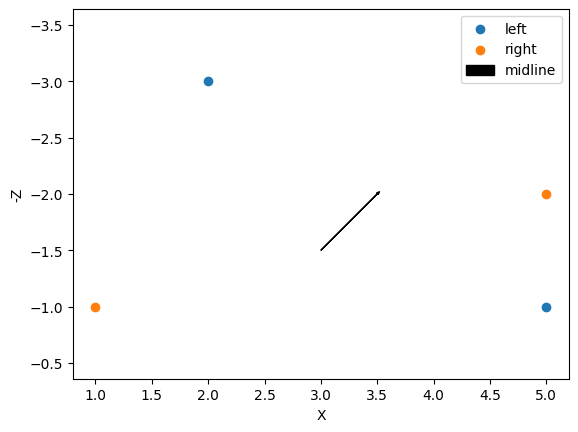

In [14]:
def plot_hand_pose_2d(hand_window_df, midline):
    midline_origin, midline_direction = midline

    right_contralateral_distance = contralateral_distance(hand_window_df, midline, "right")
    right_cd_mean = np.nanmean(right_contralateral_distance)
    right_cd_sd = np.nanstd(right_contralateral_distance)
    left_contralateral_distance = contralateral_distance(hand_window_df, midline, "left")
    left_cd_mean = np.nanmean(left_contralateral_distance)
    left_cd_sd = np.nanstd(left_contralateral_distance)
    
    print(f"Contralateral distance:")
    print(f"- left hand mean: {left_cd_mean:.3f}; SD: {left_cd_sd:.3f}")
    print(f"- right hand mean: {right_cd_mean:.3f}; SD: {right_cd_sd:.3f}")

    fig = plt.figure()
    ax = fig.add_subplot(111)
    for hand in ["left", "right"]:
        ax.scatter(
            hand_window_df[f"{hand}_position_x"],
            hand_window_df[f"{hand}_position_z"],
            label=hand,
        )
    ax.set_xlabel('X')
    ax.set_ylabel('-Z')
    ax.arrow(
        midline_origin[0], midline_origin[2],
        midline_direction[0] - midline_origin[0], midline_direction[2] - midline_origin[2],
        head_width=0.02,
        color='black', label='midline'
    )
    ax.invert_yaxis()  # Invert the y-axis
    plt.legend()
    plt.axis('equal')
    plt.show()

example_eye_ray_df = pd.DataFrame({
    "origin_x": [3, np.nan, 3],
    "origin_y": [0, np.nan, 0],
    "origin_z": [-1, np.nan, -1],
    "direction_x": [3, np.nan, 3],
    "direction_y": [0, np.nan, 0],
    "direction_z": [-3, np.nan, -3],
})
example_head_df = pd.DataFrame({
    "position_x": [5, 1],
    "position_y": [0, 0],
    "position_z": [-2, -1],
    "forward_x": [2, 5],
    "forward_y": [0, 0],
    "forward_z": [-3, -1],
})
plot_hand_pose_2d(example_hand_df, head_midline(example_head_df))

Participant: 7, Cognitive Load: 1, Trial ID: 212, Time between 2025-01-31 09:43:10.498573975+01:00 and 2025-01-31 09:43:20.498573975+01:00
Contralateral distance:
- left hand mean: -0.054; SD: 0.056
- right hand mean: -0.096; SD: 0.030


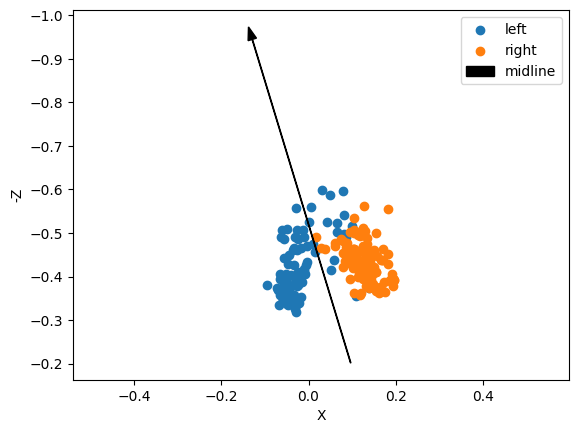

In [15]:
while True:
    window_dict = get_random_window()
    if window_dict["hand_pose"].dropna().shape[0] > 1 and window_dict["head_pose"] is not None:
        break
    
plot_hand_pose_2d(window_dict["hand_pose"], head_midline(window_dict["head_pose"]))

In [16]:
def angular_distance(quaternion_df):
    dot_product = np.abs(
        np.sum(
            quaternion_df.values * quaternion_df.shift(1).values,
            axis=1,
        )
    )  # absolute value to avoid wrap-around issues
    dot_product = np.clip(dot_product, 0, 1) # avoid numerical errors
    angular_distances = 2 * np.arccos(dot_product)
    return angular_distances

In [17]:
def process_hand_pose(hand_window_df, head_window_df):
    hand_window_df = hand_window_df.copy()
    for hand in ["left", "right"]:
        quaternion_df = hand_window_df[
            [
                f"{hand}_orientation_x",
                f"{hand}_orientation_y",
                f"{hand}_orientation_z",
                f"{hand}_orientation_w",
            ]
        ]
        hand_window_df[f"{hand}_angular_distance"] = angular_distance(
            quaternion_df
        )
        hand_window_df[f"{hand}_position_change"] = np.linalg.norm(
            hand_window_df[[f"{hand}_position_x", f"{hand}_position_y", f"{hand}_position_z"]]
            .diff(axis=0)
            .values,
            axis=1,
        )
        hand_window_df[f"{hand}_contralateral_distance"] = contralateral_distance(hand_window_df, head_midline(head_window_df), hand)
        hand_window_df[f"{hand}_contralateral_distance_relu"] = np.maximum(hand_window_df[f"{hand}_contralateral_distance"], 0)

    hand_window_df[f"max_contralateral_distance"] = np.maximum(hand_window_df["left_contralateral_distance"], hand_window_df["right_contralateral_distance"])
    columns = [column for column in hand_window_df.keys() if re.search(f"angular_distance|position_change|contralateral_distance", column)]
    feature_series = signal_features_for_sensor("hand", hand_window_df[columns])
    return feature_series

while True:
    window_dict = get_random_window()
    if window_dict["hand_pose"].dropna().shape[0] > 1 and window_dict["head_pose"] is not None:
        break

process_hand_pose(window_dict["hand_pose"], window_dict["head_pose"])

Participant: 22, Cognitive Load: 0, Trial ID: 686, Time between 2025-02-11 13:48:51.286695068+01:00 and 2025-02-11 13:49:01.286695068+01:00


{'hand_left_angular_distance_mean': np.float64(0.06556874761624366),
 'hand_left_angular_distance_std': np.float64(0.02521488962621315),
 'hand_left_angular_distance_median': np.float64(0.061791442935901844),
 'hand_left_angular_distance_mad': np.float64(0.013906290839248351),
 'hand_left_angular_distance_min': np.float64(0.0),
 'hand_left_angular_distance_max': np.float64(0.1731405549765076),
 'hand_left_angular_distance_range': np.float64(0.1731405549765076),
 'hand_left_angular_distance_iqr': np.float64(0.010256139794009536),
 'hand_left_angular_distance_skew': np.float64(1.1121917352450263),
 'hand_left_angular_distance_kurtosis': np.float64(6.779404923145542),
 'hand_left_angular_distance_energy': np.float64(0.004927743384217161),
 'hand_left_angular_distance_rms': np.float64(0.07019788732018337),
 'hand_left_position_change_mean': np.float64(0.003219406699474295),
 'hand_left_position_change_std': np.float64(0.0049736281750325205),
 'hand_left_position_change_median': np.float64(

#### Head pose

The head pose is represented by a 9-dimensional vector: 
- 3D position of the head (`position_x`, `position_y`, `position_z`)
- Normalized 3D vector indicating forward direction (`forward_x`, `forward_y`, `forward_z`)
- Normalized 3D vector indicating upward direction (`up_x`, `up_y`, `up_z`)

In [18]:
def angular_distance_3d(direction_df):
    dot_product = np.nansum(
        direction_df.values * direction_df.shift(1).values,
        axis=1,
    )
    dot_product = np.clip(dot_product, -1, 1)
    angular_distances = np.arccos(dot_product)

    return angular_distances

def process_head_pose(head_window_df):
    head_window_df = head_window_df.copy()
    head_window_df["position_change"] = np.linalg.norm(
        head_window_df[["position_x", "position_y", "position_z"]].diff(axis=0).values, axis=1
    )
    head_window_df["forward_angular_distance"] = angular_distance_3d(head_window_df[["forward_x", "forward_y", "forward_z"]])
    head_window_df["up_angular_distance"] = angular_distance_3d(head_window_df[["up_x", "up_y", "up_z"]])
    features = signal_features_for_sensor("head", head_window_df[["position_change", "forward_angular_distance", "up_angular_distance"]])
    return features

process_head_pose(get_random_window()["head_pose"])

Participant: 3, Cognitive Load: 1, Trial ID: 58, Time between 2025-01-30 09:41:00.854005127+01:00 and 2025-01-30 09:41:10.854005127+01:00


{'head_position_change_mean': np.float64(0.0015416346102224289),
 'head_position_change_std': np.float64(0.0014804152432955073),
 'head_position_change_median': np.float64(0.0009454340503519793),
 'head_position_change_mad': np.float64(0.0011515602834032425),
 'head_position_change_min': np.float64(8.891647663396843e-05),
 'head_position_change_max': np.float64(0.0073672466611318065),
 'head_position_change_range': np.float64(0.007278330184497838),
 'head_position_change_iqr': np.float64(0.001725003671532125),
 'head_position_change_skew': np.float64(1.6430622000797177),
 'head_position_change_kurtosis': np.float64(2.5691670747708106),
 'head_position_change_energy': np.float64(4.557879695332136e-06),
 'head_position_change_rms': np.float64(0.0021349191308647117),
 'head_forward_angular_distance_mean': np.float64(0.017046835837178604),
 'head_forward_angular_distance_std': np.float64(0.10793334358583438),
 'head_forward_angular_distance_median': np.float64(0.004015250628206879),
 'head

#### All HoloLens features

In [ ]:
def process_trial(trial_id, trial):
    feature_window_list = []
    for start_time, end_time in generate_trial_windows(trial["start_time"], trial["end_time"], window_size, step_size):
        window_dict = {
            "participant_id": trial["participant_id"],
            "trial_id": trial_id,
            "window_start": start_time,
            "cognitive_load": trial["cognitive_load"],
        }

        eye_window_df = participant_data[trial["participant_id"]]["eye_ray"].loc[
                participant_data[trial["participant_id"]]["eye_ray"]["timestamp"].between(start_time, end_time)
            ]
        hand_window_df = participant_data[trial["participant_id"]]["hand_pose"].loc[
                participant_data[trial["participant_id"]]["hand_pose"]["timestamp"].between(start_time, end_time)
            ]
        head_window_df = participant_data[trial["participant_id"]]["head_pose"].loc[
                participant_data[trial["participant_id"]]["head_pose"]["timestamp"].between(start_time, end_time)
            ]
        window_dict.update(process_eye_ray(eye_window_df))
        window_dict.update(process_hand_pose(hand_window_df, head_window_df))
        window_dict.update(process_head_pose(head_window_df))
        feature_window_list.append(window_dict)
    return feature_window_list

trials = [
    (trial_id, trial)
    for trial_id, trial in trial_df.iterrows()
]

feature_window_lists = Parallel(n_jobs=-1)(
    delayed(process_trial)(trial_id, trial)
    for trial_id, trial in tqdm(trials, total=len(trials))
)
hololens_feature_df = pd.DataFrame(chain.from_iterable(feature_window_lists))

  0%|          | 0/784 [00:00<?, ?it/s]

In [161]:
from statsmodels.stats.multitest import fdrcorrection

def ks_test_feature_selection(feature_df, target):
    p_values = list()
    feature_dict = dict()
    ignore_columns = ["participant_id", "trial_id", "window_start", "cognitive_load"]
    feature_columns = feature_df.columns.difference(ignore_columns)
    for column in feature_df.columns:
        if column not in ignore_columns:
            group1 = feature_df.loc[feature_df[target] == 0, column].dropna()
            group2 = feature_df.loc[feature_df[target] == 1, column].dropna()
            statistic, p_value = ks_2samp(group1, group2)
            p_values.append(p_value)
    keep, corrected_p_values = fdrcorrection(p_values, alpha=0.05, method="negcorr")  # more conservative
    feature_columns = list(feature_df[feature_columns].loc[:, keep].columns)
    return feature_columns

feature_columns = ks_test_feature_selection(hololens_feature_df, "cognitive_load")

In [173]:
best_features = list(hololens_feature_df[["cognitive_load"] + feature_columns].corr()["cognitive_load"].sort_values(ascending=False, key=abs).index)

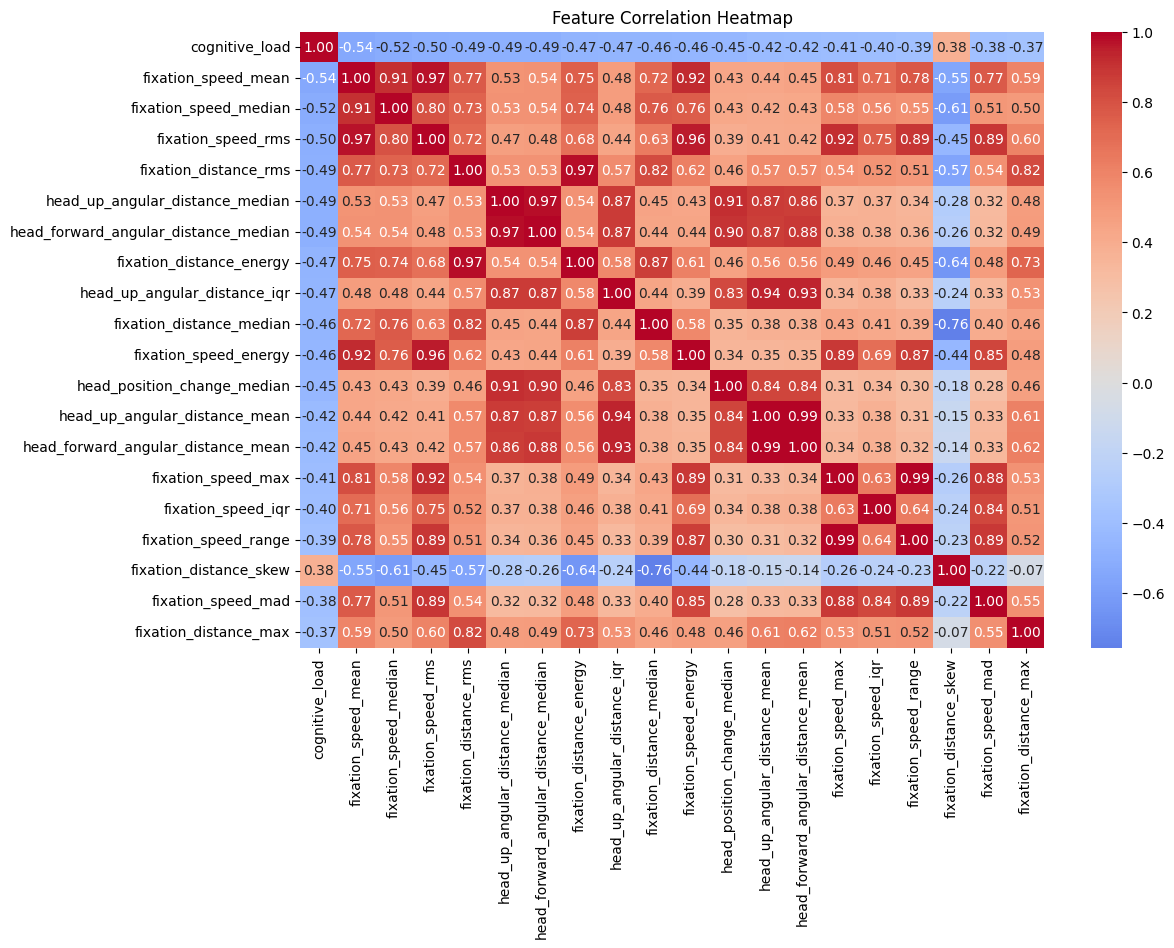

In [175]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr = hololens_feature_df[best_features[:20]].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create the heatmap
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)

# Add a title for clarity
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# create a heatmap with correlations between features
hololens_feature_df

,participant_id,trial_id,window_start,cognitive_load,head_position_change_mean,head_position_change_std,head_position_change_median,head_position_change_mad,head_position_change_min,head_position_change_max,...,hand_right_contralateral_distance_entropy,hand_right_contralateral_distance_psd,hand_max_contralateral_distance_max_freq,hand_max_contralateral_distance_mean_freq,hand_max_contralateral_distance_entropy,hand_max_contralateral_distance_psd,hand_right_contralateral_distance_relu_max_freq,hand_right_contralateral_distance_relu_mean_freq,hand_right_contralateral_distance_relu_entropy,hand_right_contralateral_distance_relu_psd
0,2,0,2025-01-29 13:05:43.529607910+01:00,1,0.002820,0.001988,0.002480,0.001616,0.000173,0.009293,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0,2025-01-29 13:05:44.529607910+01:00,1,0.002799,0.001929,0.002414,0.001532,0.000173,0.009293,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,2025-01-29 13:05:45.529607910+01:00,1,0.002616,0.001883,0.002191,0.001469,0.000173,0.009293,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,0,2025-01-29 13:05:46.529607910+01:00,1,0.002376,0.001883,0.001907,0.001457,0.000127,0.009293,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,0,2025-01-29 13:05:47.529607910+01:00,1,0.002198,0.001917,0.001545,0.001491,0.000127,0.009293,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33959,24,782,2025-02-12 16:14:35.790437012+01:00,0,0.000575,0.000560,0.000396,0.000416,0.000017,0.002915,...,2.256028,0.025824,0.032864,0.033109,2.798280,0.040103,NaN,NaN,NaN,NaN
33960,24,782,2025-02-12 16:14:36.790437012+01:00,0,0.000519,0.000558,0.000330,0.000399,0.000017,0.002915,...,2.285999,0.032956,0.018868,0.033297,2.741645,0.049508,NaN,NaN,NaN,NaN
33961,24,782,2025-02-12 16:14:37.790437012+01:00,0,0.000545,0.000557,0.000346,0.000403,0.000018,0.002915,...,2.310512,0.029005,0.033019,0.034232,2.748533,0.049508,NaN,NaN,NaN,NaN
33962,24,782,2025-02-12 16:14:38.790437012+01:00,0,0.000681,0.000632,0.000496,0.000477,0.000040,0.002915,...,2.306713,0.017080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Empatica E4

#### BVP

In [ ]:
def process_bvp(file_path):
    pass

process_bvp(f"{path}/empatica_e4_bvp.csv")

#### EDA

In [ ]:
def process_eda(file_path):
    pass

process_eda(f"{path}/empatica_e4_eda.csv")

#### Temperature

In [ ]:
def process_temperature(file_path):
    pass

process_temperature(f"{path}/empatica_e4_tmp.csv")

## Batches

Create batches using sliding windows on each of the trials.

We need:
- `batch_index`: with start and end times for all windows.
- `feature_df`: containing hand-crafted features of each batch. Ready for machine learning.
- `batch_data`: containing the data of each batch, separated by sensor. Ready for deep learning.

### Batch index

In [ ]:
def generate_trial_windows(participant_id, trial_id, window_size=10, step_size=1):
    trial_start = trial_df.loc[
        (trial_df["participant_id"] == participant_id) & (trial_df.index == trial_id), "start_time"
    ].iloc[0]
    trial_end = trial_df.loc[
        (trial_df["participant_id"] == participant_id) & (trial_df.index == trial_id), "end_time"
    ].iloc[0]
    current_time = trial_start
    while current_time + pd.Timedelta(seconds=window_size) <= trial_end:
        start_time, end_time = current_time, current_time + pd.Timedelta(seconds=window_size)
        yield (start_time, end_time)
        current_time += pd.Timedelta(seconds=step_size)
        
def generate_batch_index(trial_df, window_size, step_size):
    trial_df = trial_df[~trial_df["end_time"].isnull()].copy()
    batches = []
    for participant_id in trial_df["participant_id"].unique():
        for trial_id in trial_df[trial_df["participant_id"] == participant_id].index:
            for start_time, end_time in generate_trial_windows(participant_id, trial_id, window_size, step_size):
                cognitive_load = trial_df.loc[
                    (trial_df["participant_id"] == participant_id) & (trial_df.index == trial_id),
                    "cognitive_load",
                ].values[0]
                batches.append((participant_id, trial_id, start_time, end_time, cognitive_load))
    batch_index = (
        pd.DataFrame(batches, columns=["participant_id", "trial_id", "start_time", "end_time", "cognitive_load"])
        .reset_index()
        .rename(columns={"index": "batch_id"})
    )
    return batch_index

window_size = 10
step_size = 1
batch_index = generate_batch_index(trial_df, window_size, step_size)
batch_index.to_pickle("../data/working/batch_index.pkl")
batch_index.head()

,batch_id,participant_id,trial_id,start_time,end_time,cognitive_load
0,0,2,0,2025-01-29 13:05:43.529607910+01:00,2025-01-29 13:05:53.529607910+01:00,1
1,1,2,0,2025-01-29 13:05:44.529607910+01:00,2025-01-29 13:05:54.529607910+01:00,1
2,2,2,0,2025-01-29 13:05:45.529607910+01:00,2025-01-29 13:05:55.529607910+01:00,1
3,3,2,0,2025-01-29 13:05:46.529607910+01:00,2025-01-29 13:05:56.529607910+01:00,1
4,4,2,0,2025-01-29 13:05:47.529607910+01:00,2025-01-29 13:05:57.529607910+01:00,1


### Helpful things for next steps

Things like list of sensors, relevant columns, etc.

In [ ]:
sensor_list = ["gaze", "hand", "head"]
sample_rate_dict = {"gaze": 20, "fixation": 3, "hand": 20, "head": 20}
ignore_columns = ["session_id", "trial_id", "timestamp"]

sensor_data_dict = dict()
sensor_data_dict["gaze"] = eye_ray_df
sensor_data_dict["hand"] = hand_pose_df
sensor_data_dict["head"] = head_pose_df
feature_columns = dict()
for sensor in sensor_list:
    feature_columns[sensor] = list(sensor_data_dict[sensor].columns.difference(ignore_columns))

### Feature extraction

In [ ]:
def summarize_features(sensor, window_df):
    features = dict()
    for column in window_df.columns:
        if window_df[column].isnull().sum() < len(window_df):
            features[f"{sensor}_{column}_median"] = window_df[column].median()
            features[f"{sensor}_{column}_std"] = window_df[column].std()
            features[f"{sensor}_{column}_min"] = window_df[column].min()
            features[f"{sensor}_{column}_max"] = window_df[column].max()
    return features

#### Eye tracking

In [ ]:
def extract_gaze_features(gaze_df):
    gaze_df = gaze_df.rename(columns={"direction_x": "x", "direction_y": "y", "direction_z": "z"})
    fixation_df = extract_fixations(
        gaze_df,
        min_points_per_fixation=int(0.1 * sample_rate_dict["gaze"]),
        min_fixation_size=0.054 / 3 * 2, # 2 bits of the cube
        max_fixation_size=0.054, # 1 face of the cube
    )
    fixation_df["duration"] = (fixation_df["end"] - fixation_df["start"]).dt.total_seconds()
    fixation_df["distance"] = np.sqrt(fixation_df["x"].diff() ** 2 + fixation_df["y"].diff() ** 2 + fixation_df["z"].diff() ** 2)
    fixation_df["speed"] = fixation_df["distance"] / fixation_df["duration"]

    # angle between consecutive fixations
    vector_x = fixation_df["x"] - fixation_df["origin_x"]
    vector_y = fixation_df["y"] - fixation_df["origin_y"]
    vector_z = fixation_df["z"] - fixation_df["origin_z"]
    current_vector = np.stack([vector_x, vector_y, vector_z], axis=1)
    previous_vector = np.stack([vector_x.shift(1), vector_y.shift(1), vector_z.shift(1)], axis=1)
    dot_product = np.einsum('ij,ij->i', current_vector, previous_vector)
    norm_vector = np.linalg.norm(current_vector, axis=1)
    previous_norm_vector = np.linalg.norm(previous_vector, axis=1)
    fixation_df["angle"] = np.arccos(dot_product / (norm_vector * previous_norm_vector))

    fixation_df.drop(columns=["start", "end", "x", "y", "z", "origin_x", "origin_y", "origin_z"], inplace=True)
    fixation_features = summarize_features("fixation", fixation_df)
    return fixation_features

#### Hand pose


A hand pose is represented by a 14-dimensional vector, with 7 parameters for each hand: 
- 3 parameters encode the 3D position of the hand
- 4 parameters determine its orientation using unitary [quaternions](https://eater.net/quaternions). 

Each quaternion $q$ has a real component $q_w$, representing a rotation around an axis of rotation, represented by the imaginary components $q_x$, $q_y$ and $q_z$.

<!-- For the quaternion to be unitary, $\sqrt{q_x^2 + q_y^2 + q_z^2 + q_w^2} = 1$. We could transform the quaternions into a 3D vector and an angle of rotation in radians. The angle of rotation is determined by: 

$$2 \cdot acos(q_w)$$

To convert the components of the axis of rotation into a unitary 3D vector, we will use the formula:

$$\forall c \in \{x, y, z\}, \frac{q_c}{\sqrt{1 - q_w^2}}$$ 

A special case occurs in the absence of rotation. If this happens, read the rest of the paragraph and handle the special case. From the first formula, this would happen when $acos(q_w) = 0$, that is, when $q_w = 1$. To keep the quaternion unitary, the other components ($x, y, z$) must be zero, leading to a quaternion of the form $(1, 0, 0, 0)$. As the angle approaches zero, $\forall c \in \{x, y, z\}, q_c \to 0$, making our vector approach the origin. The problem arises when $q_w = 1$, because we would divide by 0, making our vector undefined. To avoid that, if the angle is zero, we will replace the vector with the origin $(0, 0, 0)$. -->

In [ ]:
def extract_hand_features(hand_df):
    for hand in ["left", "right"]:
        quaternion_df = hand_df[
            [
                f"{hand}_orientation_x",
                f"{hand}_orientation_y",
                f"{hand}_orientation_z",
                f"{hand}_orientation_w",
            ]
        ]

        # angular distance
        dot_product = np.abs(
            np.nansum(
                quaternion_df.values * quaternion_df.shift(1).values,
                axis=1,
            )
        )  # absolute value to avoid wrap-around issues
        dot_product = np.clip(dot_product, 0, 1) # avoid numerical errors
        hand_df[f"{hand}_orientation_angular_distance"] = 2 * np.arccos(dot_product)
        hand_df[f"{hand}_position_change"] = np.linalg.norm(
            hand_df[[f"{hand}_position_x", f"{hand}_position_y", f"{hand}_position_z"]]
            .diff(axis=0)
            .values,
            axis=1,
        )
        drop_columns = [
            column for column in hand_df.columns
            if re.match(f"{hand}_(position|orientation)_[x|y|z|w]", column)
            or "accuracy" in column  # could be useful for combining deep learning models, but not for machine learning I think
        ]
        hand_df.drop(columns=drop_columns, inplace=True)
    hand_features = summarize_features("hand", hand_df.drop(columns=["timestamp"]))
    return hand_features

#### Head pose

The head pose is represented by a 9-dimensional vector: 
- 3D position of the head (`position_x`, `position_y`, `position_z`)
- Normalized 3D vector indicating forward direction (`forward_x`, `forward_y`, `forward_z`)
- Normalized 3D vector indicating upward direction (`up_x`, `up_y`, `up_z`)

In [ ]:
def angular_distance_3d(direction_df):
    dot_product = np.nansum(
        direction_df.values * direction_df.shift(1).values,
        axis=1,
    )
    dot_product = np.clip(dot_product, -1, 1)
    angular_distances = np.arccos(dot_product)
    return angular_distances

def extract_head_features(head_df):
    head_df["position_change"] = np.linalg.norm(
        head_df[["position_x", "position_y", "position_z"]].diff(axis=0).values, axis=1
    )
    head_df["forward_angular_distance"] = angular_distance_3d(head_df[["forward_x", "forward_y", "forward_z"]])
    head_df["up_angular_distance"] = angular_distance_3d(head_df[["up_x", "up_y", "up_z"]])

    drop_columns = [
        column for column in head_df.columns
        if re.match(f"(position|forward|up)_[x|y|z]", column)
    ]
    head_df.drop(columns=drop_columns, inplace=True)
    head_features = summarize_features("head", head_df.drop(columns=["timestamp"]))
    return head_features

### Create feature_df

In [ ]:
def extract_features(batch):
    query = "session_id == @batch['session_id'] and trial_id == @batch['trial_id'] and timestamp >= @batch['start_time'] and timestamp <= @batch['end_time']"
    feature_dict = dict()
    for sensor in sensor_list:
        sensor_df = (
            sensor_data_dict[sensor]
            .query(query)
            .drop(columns=["session_id", "trial_id"])
            .copy()
        ) 
        if sensor == "gaze":
            sensor_feature_dict = extract_gaze_features(sensor_df)
        elif sensor == "hand":
            sensor_feature_dict = extract_hand_features(sensor_df)
        elif sensor == "head":
            sensor_feature_dict = extract_head_features(sensor_df)
        feature_dict.update(sensor_feature_dict)
    
    return feature_dict

feature_df = pd.DataFrame([extract_features(batch) for _, batch in batch_index.iterrows()])  # 54.5 seconds
feature_df.to_pickle("working/feature_df.pkl")
feature_df.head()

,fixation_duration_median,fixation_duration_std,fixation_duration_min,fixation_duration_max,fixation_distance_median,fixation_distance_std,fixation_distance_min,fixation_distance_max,fixation_speed_median,fixation_speed_std,...,head_position_change_min,head_position_change_max,head_forward_angular_distance_median,head_forward_angular_distance_std,head_forward_angular_distance_min,head_forward_angular_distance_max,head_up_angular_distance_median,head_up_angular_distance_std,head_up_angular_distance_min,head_up_angular_distance_max
0,0.471093,0.339892,0.046771,1.085419,0.060262,0.027569,0.015302,0.090408,0.093115,0.215167,...,0.000091,0.003910,0.003641,0.107630,0.000434,1.570796,0.008459,0.107422,0.0,1.570796
1,0.471093,0.330523,0.046771,1.085419,0.060262,0.027569,0.015302,0.090408,0.093115,0.215167,...,0.000091,0.003007,0.003572,0.107388,0.000434,1.570796,0.008371,0.107177,0.0,1.570796
2,0.517980,0.350713,0.046490,1.085419,0.050179,0.024702,0.015302,0.076121,0.085037,0.191650,...,0.000091,0.002529,0.003449,0.107655,0.000434,1.570796,0.007817,0.107438,0.0,1.570796
3,0.565422,0.322124,0.046490,1.085419,0.047059,0.024737,0.015302,0.076121,0.085037,0.192079,...,0.000042,0.002226,0.003286,0.107662,0.000434,1.570796,0.008026,0.107432,0.0,1.570796
4,0.565156,0.274288,0.046490,0.942412,0.074279,0.022242,0.038143,0.078677,0.101193,0.067829,...,0.000042,0.003288,0.003327,0.107655,0.000434,1.570796,0.007883,0.107434,0.0,1.570796


### Batch data (deep learning)

#### Fit scalers using leave-one-out

These scalers will be used to normalize the data while ensuring separation of train and test data.

In [ ]:
def leave_one_out_scalers(excluded_session_id):
    sensor_scaler_dict = dict()
    for sensor in sensor_list:
        X = (
            sensor_data_dict[sensor]
            .loc[
                sensor_data_dict[sensor]["session_id"] != excluded_session_id,
                feature_columns[sensor]
            ]
            .dropna()
            .values
        )
        scaler = StandardScaler().fit(X)
        sensor_scaler_dict[sensor] = scaler
    return sensor_scaler_dict

leave_out_session_scalers = dict()
for leave_out_session_id in trial_df["session_id"].unique():
    leave_out_session_scalers[leave_out_session_id] = leave_one_out_scalers(leave_out_session_id)

pickle.dump(leave_out_session_scalers, open("working/leave_one_out_scalers.pkl", "wb"))

In [ ]:
def get_window_data(self, session_id, sample_rate_dict, sensor, trial_id, start_time, end_time):
    # resample
    # interpolate
    X = self.data_dict[sensor].loc[
        (self.data_dict[sensor]["session_id"] == session_id)
        & (self.data_dict[sensor]["trial_id"] == trial_id)
        & (self.data_dict[sensor]["timestamp"] >= start_time)
        & (self.data_dict[sensor]["timestamp"] < end_time),
        ["timestamp"] + feature_columns[sensor],
    ]
    expected_length = sample_rate_dict[sensor] * self.window_size
    X = X[:expected_length]
    X = X.drop(columns=["timestamp"]).values
    X = leave_out_session_scalers[session_id][sensor].transform(X)
    if np.isnan(X).any():
        print("NAN values found")
        X = np.nan_to_num(X, nan=0.0)
    X = np.pad(X, ((0, expected_length - X.shape[0]), (0, 0)), constant_values=0)
    X = np.expand_dims(X, axis=0)
    return X

In [ ]:
identifier_columns = ["timestamp", "session_id", "trial_id"]

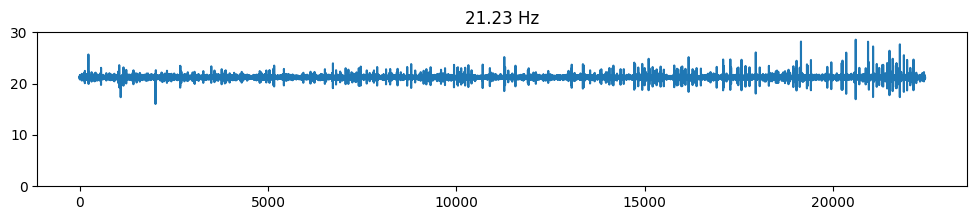

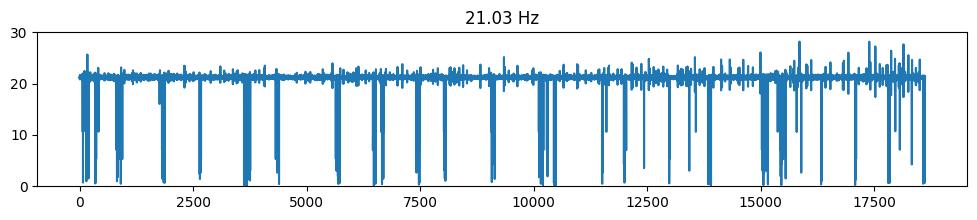

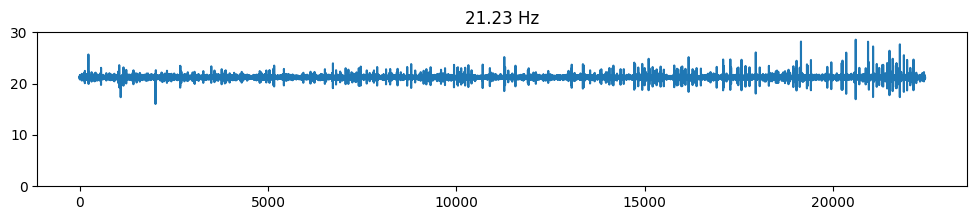

In [ ]:
def plot_sample_rate(df):
    timestamp_in_ms = df['timestamp'].astype(int) / 10**6
    sample_rate = 1000 / np.array([timestamp_in_ms.iloc[i] - timestamp_in_ms.iloc[i - 1] for i in range(1, len(df))])
    plt.figure(figsize=(12, 2))
    plt.plot(sample_rate)
    plt.ylim(0, 30)
    plt.title(f"{np.mean(sample_rate):.2f} Hz")
    plt.show()

plot_sample_rate(eye_ray_df)
plot_sample_rate(hand_pose_df)
plot_sample_rate(head_pose_df)

Although the theoretical sample rate was 30 Hz, based on the data, it's more like 20 Hz.
Each dataset will be resampled and interpolated to 20 Hz.

In [ ]:
sample_rate_dict = 20

In [ ]:
def interpolate_dataframe(raw_df, ignore_columns=["session_id", "trial_id", "timestamp", "start", "end"]):
    feature_columns = [feature_column for feature_column in raw_df.columns if feature_column not in ignore_columns]
    interpolated_df = raw_df.copy()
    for feature_column in feature_columns:
        y = interpolated_df[feature_column]
        mask = ~np.isnan(y)
        if len(y[mask]) > 0:
            interpolated_y = np.interp(
                interpolated_df["timestamp"], interpolated_df["timestamp"][mask], y[mask]
            )
            interpolated_df[feature_column] = interpolated_y
    return interpolated_df

In [ ]:
def resample_dataframe(raw_df, sample_rate=20):
    resampled_df = raw_df.copy()
    period = pd.Timedelta(seconds=1 / sample_rate)
    # Round the timestamps to the nearest interval
    resampled_df["timestamp"] = resampled_df["timestamp"].dt.floor(period)
    start_time = resampled_df["timestamp"].iloc[0]
    end_time = resampled_df["timestamp"].iloc[-1]
    num_periods = int((end_time - start_time) / period) + 1
    theoretical_times = pd.date_range(
        start=start_time,
        periods=num_periods,
        freq=period
    )
    complete_df = (
        pd.DataFrame({"timestamp": theoretical_times})
        .merge(resampled_df, on="timestamp", how="left")
        .groupby("timestamp")
        .mean()
        .reset_index()
    )

    print(f"Resampled from {len(resampled_df)} to {len(complete_df)} rows")
    return complete_df

resample_dataframe(eye_ray_df).head()

### Eye tracking

In [ ]:
eye_ray_df = resample_dataframe(eye_ray_df, sample_rate)

Resampled from 22443 to 21153 rows


In [ ]:
fixation_df = extract_fixations(
    eye_ray_df.rename(
        columns={
              "direction_x": "x", "direction_y": "y", "direction_z": "z"
              }
    ),
    min_points_per_fixation=int(0.1 * sample_rate_dict),
    min_fixation_size=0.054 / 3 * 2, # 2 bits of the cube
    max_fixation_size=0.054, # 1 face of the cube
)
fixation_df.insert(0, "session_id", np.nan)
fixation_df.insert(1, "trial_id", np.nan)

for participant_id in trial_df["session_id"].unique():
    for index, row in trial_df[trial_df["session_id"] == participant_id].iterrows():
        fixation_df.loc[(fixation_df["start"] >= row["start"]) & (fixation_df["end"] <= row["end"]), "trial_id"] = index
        fixation_df.loc[(fixation_df["start"] >= row["start"]) & (fixation_df["end"] <= row["end"]), "session_id"] = participant_id
fixation_df.head()

,session_id,trial_id,start,end,x,y,z,origin_x,origin_y,origin_z
0,NaN,NaN,2024-08-14 12:28:31.700,2024-08-14 12:28:32.050,-0.012077,-0.277806,-0.960462,-0.103872,0.007036,-0.261217
1,NaN,NaN,2024-08-14 12:28:32.150,2024-08-14 12:28:32.250,-0.275322,-0.082014,-0.957828,-0.093930,0.011127,-0.262677
2,NaN,NaN,2024-08-14 12:28:32.350,2024-08-14 12:28:32.500,-0.147442,-0.499240,-0.853814,-0.103529,0.008741,-0.255959
3,NaN,NaN,2024-08-14 12:28:32.700,2024-08-14 12:28:33.100,-0.340324,-0.463013,-0.818150,-0.104011,0.002346,-0.264965
4,NaN,NaN,2024-08-14 12:28:33.150,2024-08-14 12:28:33.350,-0.369839,-0.445797,-0.815149,-0.110238,0.003822,-0.261464


In [ ]:
fixation_df["duration"] = (fixation_df["end"] - fixation_df["start"]).dt.total_seconds()
fixation_df["distance"] = np.sqrt(fixation_df["x"].diff() ** 2 + fixation_df["y"].diff() ** 2 + fixation_df["z"].diff() ** 2)
fixation_df["speed"] = fixation_df["distance"] / fixation_df["duration"]
fixation_df.head(3)

,session_id,trial_id,start,end,x,y,z,origin_x,origin_y,origin_z,duration,distance,speed
0,NaN,NaN,2024-08-14 12:28:31.700,2024-08-14 12:28:32.050,-0.012077,-0.277806,-0.960462,-0.103872,0.007036,-0.261217,0.35,NaN,NaN
1,NaN,NaN,2024-08-14 12:28:32.150,2024-08-14 12:28:32.250,-0.275322,-0.082014,-0.957828,-0.093930,0.011127,-0.262677,0.10,0.328084,3.280841
2,NaN,NaN,2024-08-14 12:28:32.350,2024-08-14 12:28:32.500,-0.147442,-0.499240,-0.853814,-0.103529,0.008741,-0.255959,0.15,0.448609,2.990725


In [ ]:
def calculate_angles(vector_df):
    current_vector = np.array([vector_df[column].values for column in vector_df.columns]).T
    previous_vector = np.array([vector_df[column].shift(1).values for column in vector_df.columns]).T
    dot_product = np.einsum('ij,ij->i', current_vector, previous_vector)
    norm_vector = np.linalg.norm(current_vector, axis=1)
    previous_norm_vector = np.linalg.norm(previous_vector, axis=1)
    angle = np.arccos(dot_product / (norm_vector * previous_norm_vector))
    return angle

vector_x = fixation_df["x"] - fixation_df["origin_x"]
vector_y = fixation_df["y"] - fixation_df["origin_y"]
vector_z = fixation_df["z"] - fixation_df["origin_z"]
fixation_df["angle"] = calculate_angles(pd.DataFrame([vector_x, vector_y, vector_z], index=["x", "y", "z"]).T)
fixation_df.head(3)

,session_id,trial_id,start,end,x,y,z,origin_x,origin_y,origin_z,duration,distance,speed,angle
0,NaN,NaN,2024-08-14 12:28:31.700,2024-08-14 12:28:32.050,-0.012077,-0.277806,-0.960462,-0.103872,0.007036,-0.261217,0.35,NaN,NaN,NaN
1,NaN,NaN,2024-08-14 12:28:32.150,2024-08-14 12:28:32.250,-0.275322,-0.082014,-0.957828,-0.093930,0.011127,-0.262677,0.10,0.328084,3.280841,0.450794
2,NaN,NaN,2024-08-14 12:28:32.350,2024-08-14 12:28:32.500,-0.147442,-0.499240,-0.853814,-0.103529,0.008741,-0.255959,0.15,0.448609,2.990725,0.596651


In [ ]:
fixation_df[["duration", "distance", "speed", "angle"]].corr()

,duration,distance,speed,angle
duration,1.000000,-0.202535,-0.311375,-0.202223
distance,-0.202535,1.000000,0.755728,0.997123
speed,-0.311375,0.755728,1.000000,0.751612
angle,-0.202223,0.997123,0.751612,1.000000


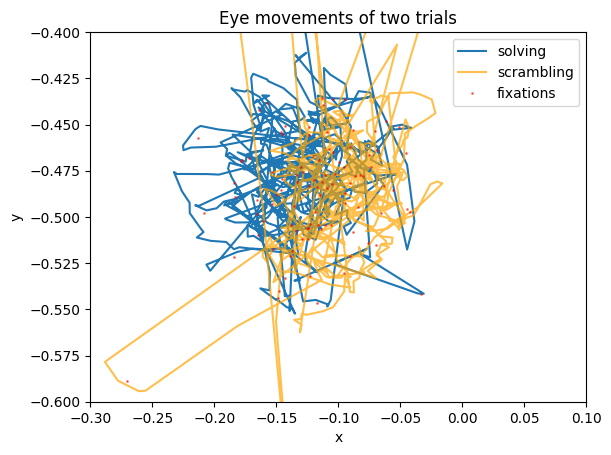

In [ ]:
scrambling = eye_ray_df.loc[eye_ray_df["trial_id"] == 6, ["direction_x", "direction_y"]]
solving = eye_ray_df.loc[eye_ray_df["trial_id"] == 7, ["direction_x", "direction_y"]]
fixations = fixation_df.loc[fixation_df["trial_id"].isin([6, 7]), ["x", "y"]]
plt.plot(solving["direction_x"], solving["direction_y"])
plt.plot(scrambling["direction_x"], scrambling["direction_y"], color="orange", alpha=0.7)
plt.plot(fixations["x"], fixations["y"], "o", color="red", alpha=0.5, markersize=1)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-0.3, 0.1)
plt.ylim(-0.6, -0.4)
plt.title("Eye movements of two trials")
plt.legend(["solving", "scrambling", "fixations"])

In [ ]:
# make fixation_df compatible with the other sensor dataframes
fixation_df.insert(0, "timestamp", fixation_df["start"])
fixation_df.drop(columns=["start", "end", "origin_x", "origin_y", "origin_z"], inplace=True)
fixation_df.head(3)

,timestamp,session_id,trial_id,x,y,z,duration,distance,speed,angle
0,2024-08-14 12:28:31.700,NaN,NaN,-0.012077,-0.277806,-0.960462,0.35,NaN,NaN,NaN
1,2024-08-14 12:28:32.150,NaN,NaN,-0.275322,-0.082014,-0.957828,0.10,0.328084,3.280841,0.450794
2,2024-08-14 12:28:32.350,NaN,NaN,-0.147442,-0.499240,-0.853814,0.15,0.448609,2.990725,0.596651


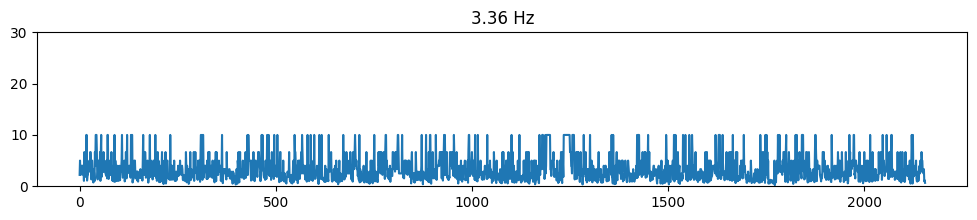

In [ ]:
plot_sample_rate(fixation_df)

In [ ]:
fixation_df = resample_dataframe(fixation_df, 3, interpolate=False)

Resampled from 2157 to 3172 rows


In [ ]:
eye_ray_df = eye_ray_df[eye_ray_df["trial_id"].notnull()].reset_index(drop=True)
eye_ray_df.to_pickle("working/eye_ray_df.pkl")
fixation_df = fixation_df[fixation_df["trial_id"].notnull()].reset_index(drop=True)
fixation_df.to_pickle("working/fixation_df.pkl")

### Hand pose


A hand pose is represented by a 14-dimensional vector, with 7 parameters for each hand: 
- 3 parameters encode the 3D position of the hand
- 4 parameters determine its orientation using unitary [quaternions](https://eater.net/quaternions). 

Each quaternion $q$ has a real component $q_w$, representing a rotation around an axis of rotation, represented by the imaginary components $q_x$, $q_y$ and $q_z$.

<!-- For the quaternion to be unitary, $\sqrt{q_x^2 + q_y^2 + q_z^2 + q_w^2} = 1$. We could transform the quaternions into a 3D vector and an angle of rotation in radians. The angle of rotation is determined by: 

$$2 \cdot acos(q_w)$$

To convert the components of the axis of rotation into a unitary 3D vector, we will use the formula:

$$\forall c \in \{x, y, z\}, \frac{q_c}{\sqrt{1 - q_w^2}}$$ 

A special case occurs in the absence of rotation. If this happens, read the rest of the paragraph and handle the special case. From the first formula, this would happen when $acos(q_w) = 0$, that is, when $q_w = 1$. To keep the quaternion unitary, the other components ($x, y, z$) must be zero, leading to a quaternion of the form $(1, 0, 0, 0)$. As the angle approaches zero, $\forall c \in \{x, y, z\}, q_c \to 0$, making our vector approach the origin. The problem arises when $q_w = 1$, because we would divide by 0, making our vector undefined. To avoid that, if the angle is zero, we will replace the vector with the origin $(0, 0, 0)$. -->

In [ ]:
hand_pose_df = resample_dataframe(hand_pose_df, sample_rate_dict)  # in the future we could try without interpolation

Resampled from 18623 to 21068 rows


In [ ]:
def angular_distance(quaternion_df):
    dot_product = np.abs(
        np.nansum(
            quaternion_df.values * quaternion_df.shift(1).values,
            axis=1,
        )
    )  # absolute value to avoid wrap-around issues
    dot_product = np.clip(dot_product, 0, 1) # avoid numerical errors
    angular_distances = 2 * np.arccos(dot_product)

    return angular_distances

for hand in ["left", "right"]:
    quaternion_df = hand_pose_df[
        [
            f"{hand}_orientation_x",
            f"{hand}_orientation_y",
            f"{hand}_orientation_z",
            f"{hand}_orientation_w",
        ]
    ]
    hand_pose_df[f"{hand}_orientation_angular_distance"] = angular_distance(
        quaternion_df
    )
    hand_pose_df[f"{hand}_position_change"] = np.linalg.norm(
        hand_pose_df[[f"{hand}_position_x", f"{hand}_position_y", f"{hand}_position_z"]]
        .diff(axis=0)
        .values,
        axis=1,
    )

In [ ]:
hand_pose_df = hand_pose_df[hand_pose_df["trial_id"].notnull()].reset_index(drop=True)
hand_pose_df.to_pickle("working/hand_pose_df.pkl")

### Head pose

The head pose is represented by a 9-dimensional vector: 
- 3D position of the head (`position_x`, `position_y`, `position_z`)
- Normalized 3D vector indicating forward direction (`forward_x`, `forward_y`, `forward_z`)
- Normalized 3D vector indicating upward direction (`up_x`, `up_y`, `up_z`)

In [ ]:
head_pose_df = resample_dataframe(head_pose_df, sample_rate_dict)

Resampled from 22443 to 21153 rows


In [ ]:
def angular_distance_3d(direction_df):
    dot_product = np.nansum(
        direction_df.values * direction_df.shift(1).values,
        axis=1,
    )
    dot_product = np.clip(dot_product, -1, 1)
    angular_distances = np.arccos(dot_product)

    return angular_distances

head_pose_df["position_change"] = np.linalg.norm(
    head_pose_df[["position_x", "position_y", "position_z"]].diff(axis=0).values, axis=1
)
head_pose_df["forward_angular_distance"] = angular_distance_3d(head_pose_df[["forward_x", "forward_y", "forward_z"]])
head_pose_df["up_angular_distance"] = angular_distance_3d(head_pose_df[["up_x", "up_y", "up_z"]])

In [ ]:
head_pose_df = head_pose_df[head_pose_df["trial_id"].notnull()].reset_index(drop=True)
head_pose_df.to_pickle("working/head_pose_df.pkl")